In [1]:
from scipy.io import netcdf, loadmat
import numpy as np
from pylab import clf, plot, show, floor, ceil, imshow
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
#xlabel, ylabel, legend, savefig, colorbar, title, clim, pcolor, cm, contourf
import os
import csv
import sys
import glob
from IPython.display import display, Math, Latex
from python_functions import *

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days
:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [20]:
def grad_calc(Depth, hfacc, dxF, dyF, X, Y, Z, res): 
    Sx = np.zeros_like(hfacc[0,:,:])
    Sy = np.zeros_like(hfacc[0,:,:])
    
    for x in range(len(X)-1)[1:]:
        for y in range(len(Y)-1)[1:]:
            if x == 0 and y == 0:
                Sx[y,x] = -(Depth[y,1]-Depth[y,0])/(dxF[y,1]-dxF[y,0])
                Sy[y,x] = -(Depth[1,x]-Depth[0,x])/(dyF[1,x]-dyF[1,x])
            elif x == 0 and y == (len(Y)-1):
                Sx[y,x] = -(Depth[y,x+1]-Depth[y,0])/(dxF[y,1]-dxF[y,0])
                Sy[y,x] = -(Depth[(len(Y)-1),x]-Depth[y-1,x])/(dyF[(len(Y)-1),x]-dyF[y-1,x])
            elif x == (len(X)-1) and y == 0:
                Sx[y,x] = -(Depth[y,(len(X)-1)]-Depth[y,x-1])/(dxF[y,(len(X)-1)]-dxF[y,x-1])
                Sy[y,x] = -(Depth[y+1,x]-Depth[0,x])/(dyF[y+1,x]-dyF[0,x])
            elif x == (len(X)-1) and y == (len(Y)-1):
                Sx[y,x] = -(Depth[y,(len(X)-1)]-Depth[y,x-1])/(dxF[y,(len(X)-1)]-dxF[y,x-1])
                Sy[y,x] = -(Depth[y+1,x]-Depth[y-1,x])/(dyF[(len(Y)-1),x]-dyF[y-1,x])
            elif x == 0:
                Sx[y,x] = -(Depth[y,1]-Depth[y,0])/(dxF[y,1]-dxF[y,0])
                Sy[y,x] = -(Depth[y+1,x]-Depth[y-1,x])/(dyF[y+1,x]-dyF[y-1,x])
            elif x == (len(X)-1):
                Sx[y,x] = -(Depth[y,(len(X)-1)]-Depth[y,x-1])/(dxF[y,(len(X)-1)]-dxF[y,x-1])
                Sy[y,x] = -(Depth[y+1,x]-Depth[y-1,x])/(dyF[y+1,x]-dyF[y-1,x])
            elif y == 0:
                Sx[y,x] = -(Depth[y,x+1]-Depth[y,x-1])/(dxF[y,x+1]-dxF[y,x-1])
                Sy[y,x] = -(Depth[1,x]-Depth[0,x])/(dyF[1,x]-dyF[0,x])
            elif y == (len(Y)-1):
                Sx[y,x] = -(Depth[y,x+1]-Depth[y,x-1])/(dxF[y,x+1]-dxF[y,x-1])
                Sy[y,x] = -(Depth[(len(Y)-1),x]-Depth[y-1,x])/(dyF[(len(Y)-1),x]-dyF[y-1,x])
            elif res == 36 and y == 69:
                Sx[y,x] = -(Depth[y,x+1]-Depth[y,x-1])/(dxF[y,x+1]-dxF[y,x-1])
                Sy[y,x] = -(Depth[y+1,x]-Depth[y-1,x])/(dyF[y+2,x]-dyF[y,x])
            else:
                Sx[y,x] = -(Depth[y,x+1]-Depth[y,x-1])/(dxF[y,x+1]-dxF[y,x-1])
                Sy[y,x] = -(Depth[y+1,x]-Depth[y-1,x])/(dyF[y+1,x]-dyF[y-1,x])
                
    return Sx,Sy

def grid(res):
    if res == 18:
        file2read = netcdf.NetCDFFile("/scratch/general/am8e13/results18km/grid.nc",'r')
        nx = 420
        ny = 384
        k = 2
        
    elif res == 9:
        file2read = netcdf.NetCDFFile("/scratch/general/am8e13/results9km/grid.nc",'r')
        nx = 840
        ny = 768
        k = 4
        
    elif res == 36:
        file2read = netcdf.NetCDFFile("/scratch/general/am8e13/results36km/grid.nc",'r')
        nx = 210
        ny = 192
        k = 1
        
    Depth = file2read.variables['Depth']
    Depth = Depth[:]*1
    hfacc=file2read.variables['HFacC']
    hfacc=hfacc[:]*1
    dxF = file2read.variables['dxF']
    dxF = dxF[:]*1
    dyF = file2read.variables['dyF']
    dyF = dyF[:]*1
    X = file2read.variables['X']
    X = X[:]*1
    Y = file2read.variables['Y']
    Y = Y[:]*1
    Z = file2read.variables['Z']
    Z = Z[:]*1
    
    return Depth, hfacc, dxF, dyF, X, Y, Z, nx, ny, k
    

In [25]:
def grad_calc_mod(Depth, hfacc, dxF, dyF, X, Y, Z, res): 
    Sx = np.zeros_like(hfacc[0,:,:])
    Sy = np.zeros_like(hfacc[0,:,:])
    
    dx = res*1000
    dy = res*1000
    
    for x in range(len(X)-1)[1:]:
        for y in range(len(Y)-1)[1:]:
            if x == 0 and y == 0:
                Sx[y,x] = -(Depth[y,1]-Depth[y,0])/(dx)
                Sy[y,x] = -(Depth[1,x]-Depth[0,x])/(dy)
            elif x == 0 and y == (len(Y)-1):
                Sx[y,x] = -(Depth[y,x+1]-Depth[y,0])/(dx)
                Sy[y,x] = -(Depth[(len(Y)-1),x]-Depth[y-1,x])/(dy)
            elif x == (len(X)-1) and y == 0:
                Sx[y,x] = -(Depth[y,(len(X)-1)]-Depth[y,x-1])/(dx)
                Sy[y,x] = -(Depth[y+1,x]-Depth[0,x])/(dy)
            elif x == (len(X)-1) and y == (len(Y)-1):
                Sx[y,x] = -(Depth[y,(len(X)-1)]-Depth[y,x-1])/(dx)
                Sy[y,x] = -(Depth[y+1,x]-Depth[y-1,x])/(dy)
            elif x == 0:
                Sx[y,x] = -(Depth[y,1]-Depth[y,0])/(dx)
                Sy[y,x] = -(Depth[y+1,x]-Depth[y-1,x])/(dy)
            elif x == (len(X)-1):
                Sx[y,x] = -(Depth[y,(len(X)-1)]-Depth[y,x-1])/(dx)
                Sy[y,x] = -(Depth[y+1,x]-Depth[y-1,x])/(dy)
            elif y == 0:
                Sx[y,x] = -(Depth[y,x+1]-Depth[y,x-1])/(dx)
                Sy[y,x] = -(Depth[1,x]-Depth[0,x])/(dy)
            elif y == (len(Y)-1):
                Sx[y,x] = -(Depth[y,x+1]-Depth[y,x-1])/(dx)
                Sy[y,x] = -(Depth[(len(Y)-1),x]-Depth[y-1,x])/(dy)
            elif res == 36 and y == 69:
                Sx[y,x] = -(Depth[y,x+1]-Depth[y,x-1])/(dx)
                Sy[y,x] = -(Depth[y+1,x]-Depth[y-1,x])/(dy)
            else:
                Sx[y,x] = -(Depth[y,x+1]-Depth[y,x-1])/(dx)
                Sy[y,x] = -(Depth[y+1,x]-Depth[y-1,x])/(dy)
            
    return Sx,Sy
                

In [26]:
def equations(res):
    
    Depth, hfacc, dxF, dyF, X, Y, Z, nx, ny, k = grid(res)
    
    dt = 0.1 #600
    dx = 100
    dy = 100
    
    # Calculating matrix:
    #  (-1 1 . . . . . 0 0 0 )
    #  (0 -1 1 . . . . . . 0 )
    #  (0 0 -1 1 . . . 0 0 0 )
    #  .........
    #  (0 0 0 0 0 0 0 0 0 0-1 )

    id_y = np.zeros((ny,ny))
    for i in range(1,ny-1):
        id_y[i,i-1] = -dt/(2*dx)
        id_y[i,i+1] = dt/(2*dx)

    # Calculating matrix:
    #  (-1 0 0 . . . . . 0 0 0 )
    #  (1 -1 0 0 . . . . . . 0 )
    #  (0 1 -1 0 1 . . . 0 0 0 )
    #  (0 0  1  .....    1 -1 0 )
    #  ( . . . . . . . . . 1 0 )
    #  (0 0 1 0 0 0 0 0 0 0 -1 )

    id_x = np.zeros((nx,nx))
    for i in range(1,nx-1):
        id_x[i-1,i] = -dt/(2*dx)
        id_x[i+1,i] = dt/(2*dx)

    diff_x = np.zeros_like(id_x)
    diff_y = np.zeros_like(id_y)
    err = 1
    for j in range(1,nx-1,1):
        diff_x[j+1,j] = dt/(2*dx)*err
        diff_x[j-1,j] = dt/(2*dx)*err
        diff_x[j,j] = -dt/(dx)*err

    for j in range(1,ny-1,1):
        diff_y[j+1,j] = dt/(2*dx)*err
        diff_y[j-1,j] = dt/(2*dx)*err
        diff_y[j,j] = -dt/(dx)*err
    
    Sx,Sy = grad_calc_mod(Depth1, hfacc, dxF, dyF, X, Y, Z, res)    
    Sy[Sy>20]=20
    Sy[Sy<-20]=-20
    Sx[Sx>20]=20
    Sx[Sx<-20]=-20
    
    S0 = S0 = np.zeros_like(Sx)
    S0[70*k:80*k,34*k:42*k] = 10
    
    U = np.zeros_like(S0)
    U[:,:] = 20
    V = np.zeros_like(S0)
    V[:,:] = 20
    
    return Sx,Sy,id_x,id_y,diff_x,diff_y,S0,U,V,hfacc
Sx,Sy,id_x,id_y,diff_x,diff_y,S0,U,V,hfacc = equations(36)

0.0115555555556


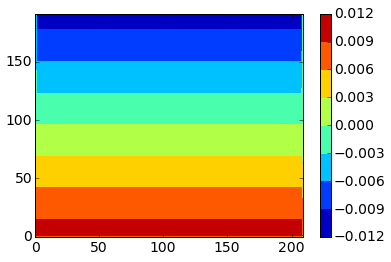

In [44]:
Depth, hfacc, dxF, dyF, X, Y, Z, nx, ny, k = grid(36)

Depth1 = np.zeros_like(Depth)
for xx in range(len(X)):
    for yy in range(len(Y)):
        Depth1[yy,xx] = (xx - len(X)/2)**2 + (yy - len(Y)/2)**2
plt.contourf(Sy)
plt.colorbar()
print Sx.max()

In [42]:
S1 = np.array(S0)
S2 = np.array(S0)
S3 = np.array(S0)
for i in range(0,1000):
    #print U.shape,V.shape,id_x.shape,id_y.shape
    for x in range(S1.shape[0]):
        S1[x,:] = S1[x,:] + np.dot(id_x*Sx[x,:]*1000,S1[x,:]) + np.dot(diff_x,S2[x,:]) 
    for y in range(S1.shape[1]):
        S2[:,y] = S2[:,y] + np.dot(id_y*Sy[:,y]*1000,S2[:,y]) + np.dot(diff_y,S2[:,y]) 
        
    for x in range(S1.shape[0]):
        S3[x,:] = S3[x,:] + np.dot(id_x*Sx[x,:]*1000,S3[x,:]) + np.dot(diff_x,S3[x,:]) 
    for y in range(S1.shape[1]):
        S3[:,y] = S3[:,y] + np.dot(id_y*Sy[:,y]*1000,S3[:,y]) + np.dot(diff_y,S3[:,y]) 

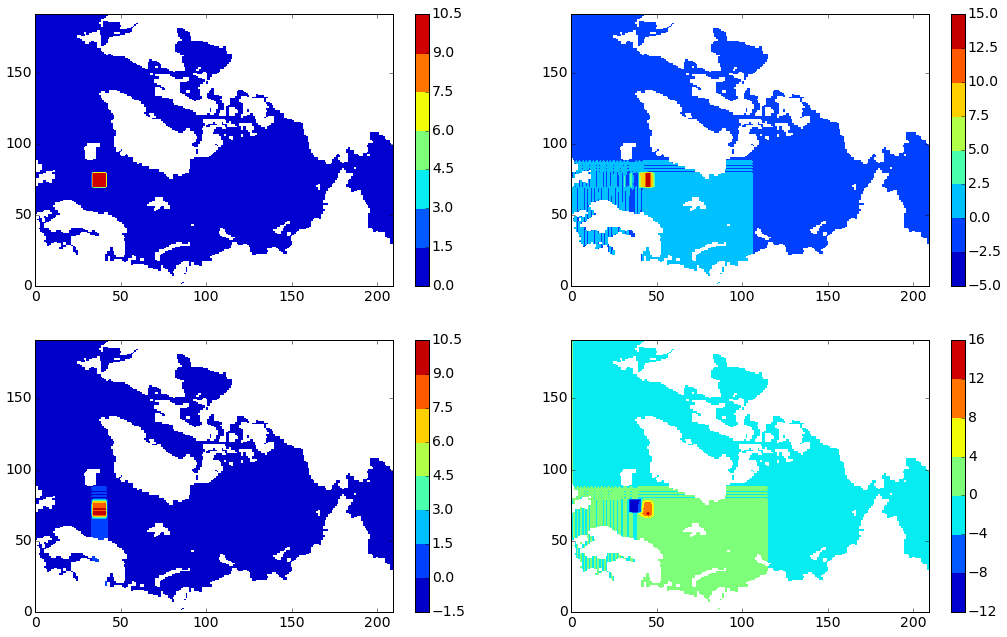

In [43]:
#S[hfacc[0,:,:]==0]=np.nan
S00 = np.array(S0)
S00[hfacc[0,:,:]==0]=np.nan
fig, axes = plt.subplots(2,2)
a0 = axes[0,0].contourf(S00)
cbar = fig.colorbar(a0 , ax=axes[0,0])
S1[hfacc[0,:,:]==0]=np.nan
a1 = axes[0,1].contourf(S1)
cbar = fig.colorbar(a1 , ax=axes[0,1])
S2[hfacc[0,:,:]==0]=np.nan
a2 = axes[1,0].contourf(S2)
cbar = fig.colorbar(a2 , ax=axes[1,0])
S3[hfacc[0,:,:]==0]=np.nan
a3 = axes[1,1].contourf(S3-S0)
cbar = fig.colorbar(a3 , ax=axes[1,1])

fig.subplots_adjust(right=2.4,top=2.2)

In [6]:
def nangrid(field,res):
    ### This script fills the field with nans in the right bit
    if res == 18:
        x="/scratch/general/am8e13/results18km/"        
        nx = 420
        ny = 384 
    elif res == 36:
        x="/scratch/general/am8e13/results36km/"
        nx = 210
        ny = 192
    file2read = netcdf.NetCDFFile(x+"grid.nc",'r')
    hfacc = file2read.variables['HFacC']
    hfacc = hfacc[:]*1
    
    if len(field.shape) == 4 :
        field[:,hfacc == 0] = np.nan
    elif len(field.shape) == 3 :
        field[hfacc == 0] = np.nan
    elif len(field.shape) == 2 :
        field[hfacc[0,:,:] == 0] = np.nan
    
    return field

In [7]:
x="/scratch/general/am8e13/results18km/"        
file2read = netcdf.NetCDFFile(x+"grid.nc",'r')
hfacc = file2read.variables['HFacC']
hfacc = hfacc[:]*1

In [8]:
## 1 D version of the advection equation

<matplotlib.colorbar.Colorbar instance at 0x2b72ed18f5f0>

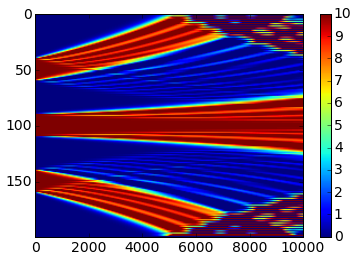

In [69]:
dt = 0.00001
dx = 1
S_1d = np.zeros(200)
S_1d[40:60]=10
S_1d[90:110]=10
S_1d[140:160]=10
V_1d = np.zeros_like(S_1d)
for x in range(200):
    V_1d[x]= -(x - 200/2)*10

id_1d = np.zeros((200, 200))
for j in range(0,198,1):
    id_1d[j+1,j] = dt/dx*V_1d[j+1]
    id_1d[j,j] = -dt/dx*V_1d[j]
id_1d[199,199]=-dt/dx*V_1d[j]

id_2o_1d = np.zeros((200, 200))
for j in range(1,198,1):
    id_2o_1d[j+1,j] = -dt/(2*dx)*V_1d[j+1]
    id_2o_1d[j-1,j] = dt/(2*dx)*V_1d[j-1]
    
diff = np.zeros_like(id_1d)
err = 0.1
for j in range(1,198,1):
    diff[j+1,j] = dt/(2*dx)*err
    diff[j-1,j] = dt/(2*dx)*err
    diff[j,j] = -dt/(dx)*err
    
# Timesteps
ts = 10000
Stime = np.zeros((200,ts))
Stime[:,0]=S_1d
for t in range(1,ts,1):
    if t > ts/3:
        jj = 1
    else :
        jj = 1
    Stime[:,t] = np.dot(jj*id_2o_1d,Stime[:,t-1]) + Stime[:,t-1] + np.dot(diff,np.ones(200))
    
plt.imshow(Stime,aspect='auto',vmin=0,vmax=10)
plt.colorbar()

In [67]:
help(imshow)

Help on function imshow in module matplotlib.pyplot:

imshow(X, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, shape=None, filternorm=1, filterrad=4.0, imlim=None, resample=None, url=None, hold=None, **kwargs)
    Display an image on the axes.
    
    Parameters
    -----------
    X : array_like, shape (n, m) or (n, m, 3) or (n, m, 4)
        Display the image in `X` to current axes.  `X` may be a float
        array, a uint8 array or a PIL image. If `X` is an array, it
        can have the following shapes:
    
        - MxN -- luminance (grayscale, float array only)
        - MxNx3 -- RGB (float or uint8 array)
        - MxNx4 -- RGBA (float or uint8 array)
    
        The value for each component of MxNx3 and MxNx4 float arrays
        should be in the range 0.0 to 1.0; MxN float arrays may be
        normalised.
    
    cmap : `~matplotlib.colors.Colormap`, optional, default: None
        If None, default to r